<a href="https://colab.research.google.com/github/HenokBerhanu/disag_vcc/blob/master/VCC2024f1_e1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load and preprocess data
data = pd.read_csv('cpu_memory_usage_f1_e1_split.txt', delimiter='\t')
data.columns = data.columns.str.strip()
data['Bandwidth'] = data['CPU-usage'] * data['Memory-usage'] / 1e6

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['CPU-usage', 'Memory-usage', 'Bandwidth']])

In [ ]:
# Prepare sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, :])
    return np.array(X), np.array(y)

In [ ]:
# Sequence length
seq_length = 10

# Assuming scaled_data is defined and is a NumPy array
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Build improved LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(seq_length, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(3)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=64,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 3.3783 - mae: 0.8553 - val_loss: 2.1034 - val_mae: 0.3326 - learning_rate: 0.0010
Epoch 2/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 2.3159 - mae: 0.5121 - val_loss: 1.8317 - val_mae: 0.3504 - learning_rate: 0.0010
Epoch 3/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.8527 - mae: 0.3814 - val_loss: 1.5941 - val_mae: 0.3684 - learning_rate: 0.0010
Epoch 4/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.5216 - mae: 0.3138 - val_loss: 1.3852 - val_mae: 0.3751 - learning_rate: 0.0010
Epoch 5/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1.2733 - mae: 0.2701 - val_loss: 1.2038 - val_mae: 0.3719 - learning_rate: 0.0010
Epoch 6/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.0748 - mae: 0.2410 - val_loss: 1.0602 - val_mae: 0.3782 - learning_rate: 0.0010
Epoch 7/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.9171 - mae: 0.2203 - val_loss: 0.9328 - val_mae: 0.3686 - learning_rate: 0.0010
Epoch 

In [ ]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

Test Loss: 0.0238, Test MAE: 0.0986


In [ ]:
# Make predictions
predictions = model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


In [ ]:
# Inverse transform the scaled data
y_test_original = scaler.inverse_transform(y_test)
predictions_original = scaler.inverse_transform(predictions)

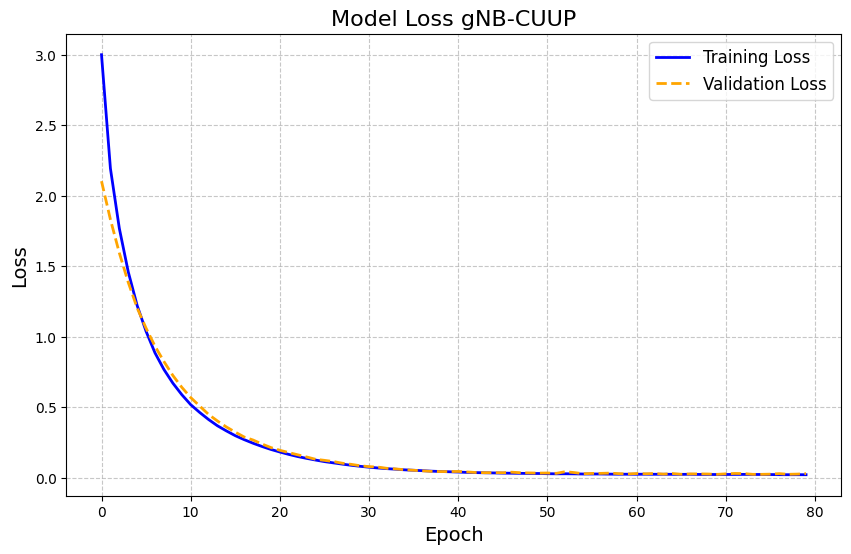

In [ ]:
# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--', linewidth=2)
plt.title('Model Loss gNB-CUUP', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
#plt.yscale('log')
plt.show()

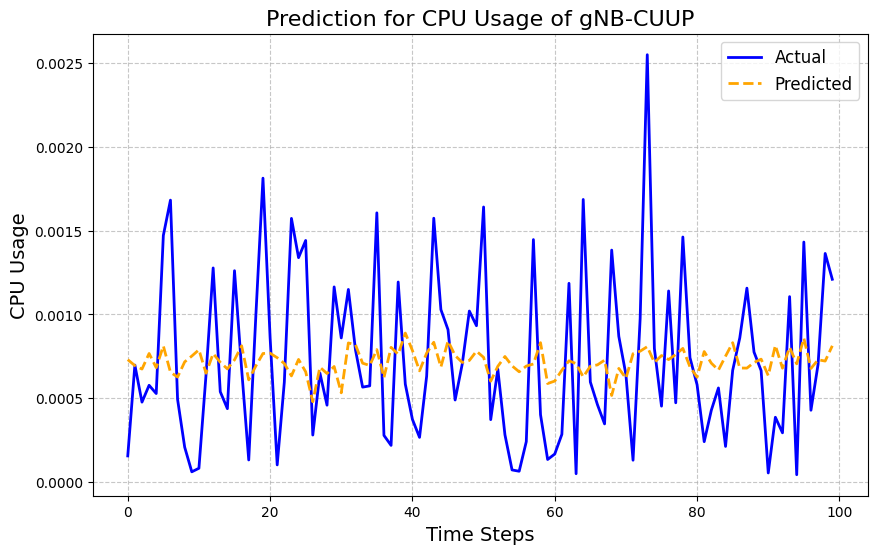

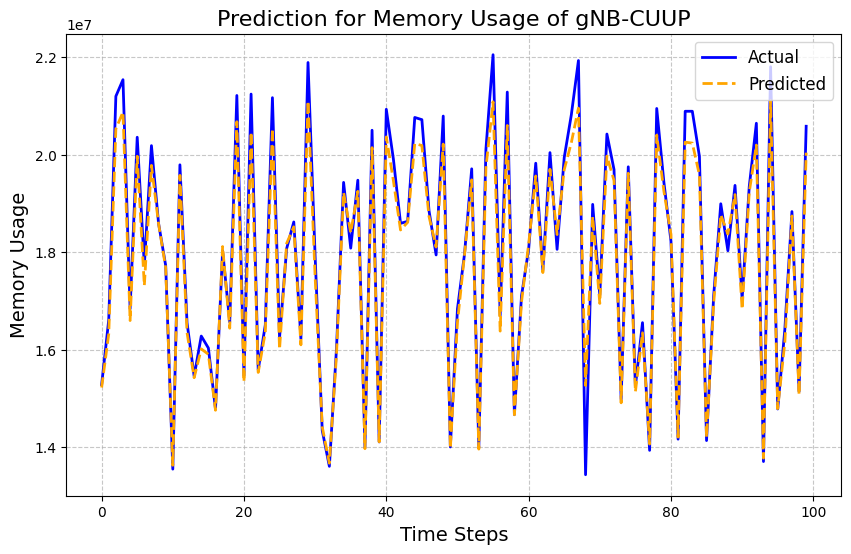

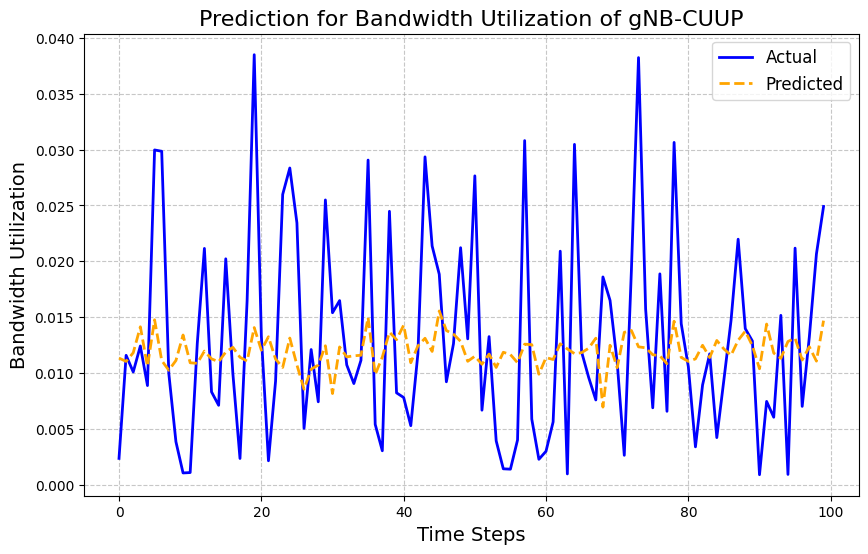

In [ ]:
# Plot results for each feature
# List of features to plot
features = ['CPU Usage', 'Memory Usage', 'Bandwidth Utilization']

# Loop through each feature and plot actual vs. predicted
for i in range(3):
    plt.figure(figsize=(10, 6))

    # Plot actual values
    plt.plot(y_test_original[:100, i], label='Actual', color='blue', linewidth=2)

    # Plot predicted values with a different style
    plt.plot(predictions_original[:100, i], label='Predicted', color='orange', linestyle='--', linewidth=2)

    # Add title and labels
    plt.title(f'Prediction for {features[i]} of gNB-CUUP', fontsize=16)
    plt.xlabel('Time Steps', fontsize=14)
    plt.ylabel(features[i], fontsize=14)

    # Add grid lines for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add legend
    plt.legend(fontsize=12)

    # Show the plot
    plt.show()

In [ ]:
# Calculate and print MAPE for each feature
for i in range(3):
    mape = np.mean(np.abs((y_test_original[:, i] - predictions_original[:, i]) / y_test_original[:, i])) * 100
    print(f"MAPE for {features[i]}: {mape:.2f}%")

MAPE for CPU Usage: 168.39%
MAPE for Memory Usage: 1.60%
MAPE for Bandwidth Utilization: 156.13%


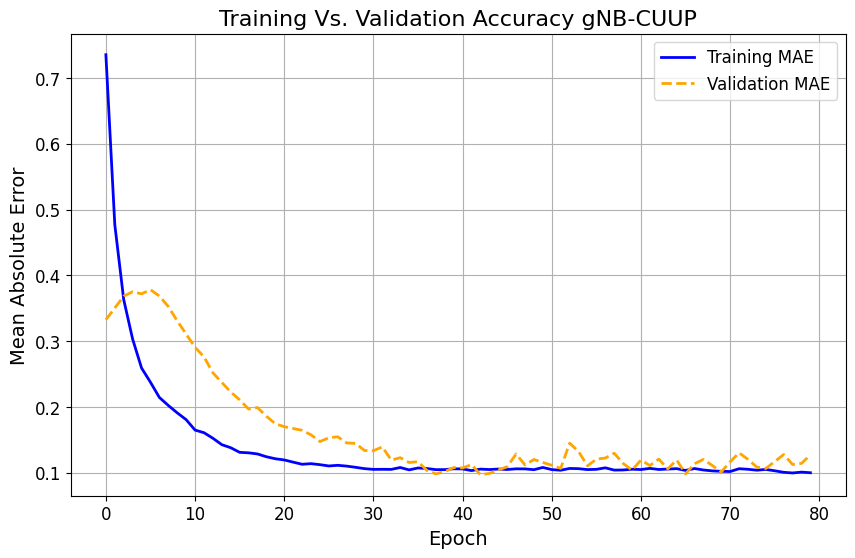

In [ ]:
# Plot training vs. validation MAE
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE', color='blue', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', color='orange', linestyle='--', linewidth=2)
plt.title('Training Vs. Validation Accuracy gNB-CUUP', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.grid(True)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
# Calculate overall regression metrics
mse = mean_squared_error(y_test_original, predictions_original)
mae = mean_absolute_error(y_test_original, predictions_original)
r2 = r2_score(y_test_original, predictions_original)
print(f"Overall Mean Squared Error: {mse:.4f}")
print(f"Overall Mean Absolute Error: {mae:.4f}")
print(f"Overall R-squared Score: {r2:.4f}")

Overall Mean Squared Error: 92031150748.1590
Overall Mean Absolute Error: 96586.2507
Overall R-squared Score: 0.3319


In [ ]:
# Calculate feature-specific metrics
for i, feature in enumerate(features):
    mse = mean_squared_error(y_test_original[:, i], predictions_original[:, i])
    mae = mean_absolute_error(y_test_original[:, i], predictions_original[:, i])
    r2 = r2_score(y_test_original[:, i], predictions_original[:, i])
    print(f"\nMetrics for {feature}:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R-squared: {r2:.4f}")


Metrics for CPU Usage:
MSE: 0.0000
MAE: 0.0004
R-squared: 0.0126

Metrics for Memory Usage:
MSE: 276093452244.4770
MAE: 289758.7448
R-squared: 0.9539

Metrics for Bandwidth Utilization:
MSE: 0.0001
MAE: 0.0069
R-squared: 0.0291


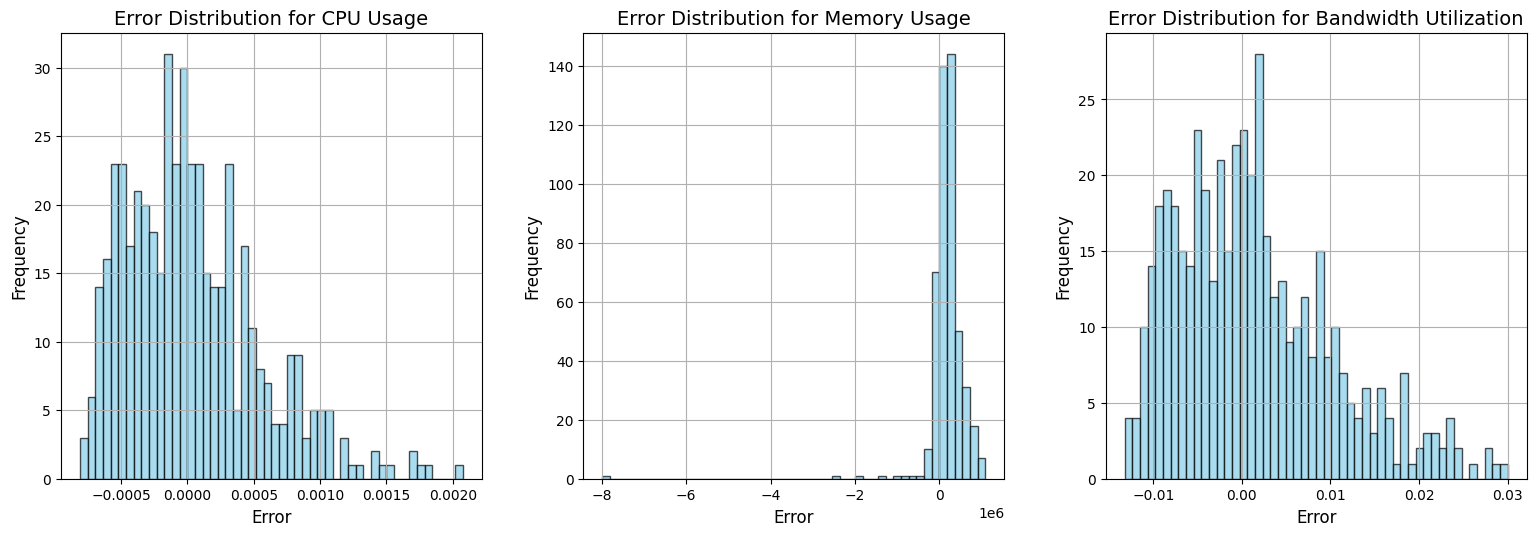

In [ ]:
# Plot error distribution
errors = y_test_original - predictions_original
plt.figure(figsize=(16, 6))
for i, feature in enumerate(features):
    plt.subplot(1, 3, i+1)
    plt.hist(errors[:, i], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'Error Distribution for {feature}', fontsize=14)
    plt.xlabel('Error', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
plt.tight_layout(pad=3.0)
plt.show()